(theory)=
# Introduction to the Hierarchical Gaussian Filter
In this notebook, we introduce the main concepts on which the Hierarchical Gaussian Filter (HGF) is based. We describe the main equations and illustrate the examples with Python code. We start with the generative model of the HGF, which describes how the model assumes that the data is being generated. This generative structure is then used to filter the observation (i.e. the sensory part of the model), which is then used by the agent to produce behaviours (i.e. the action part of the model). Next, we show how this model can be "inverted" and used by an agent to infer parameter values that generate the sensory inputs. From there, we discuss the notion of prediction error and how derivations of the model can be used to infer probability densities given observed behavioural outcomes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## The generative model

### Gaussian Random Walks
To illustrate the generative model on which the HGF is based, we will start with a simple  two-level continuous HGF (see also the tutorial {ref}`continuous_hgf`). The generative model that underpins the continuous HGF is a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the variance of the distribution. In the example below, we use $\sigma^2 = 1$ and $x_1^{(0)} = 0$.

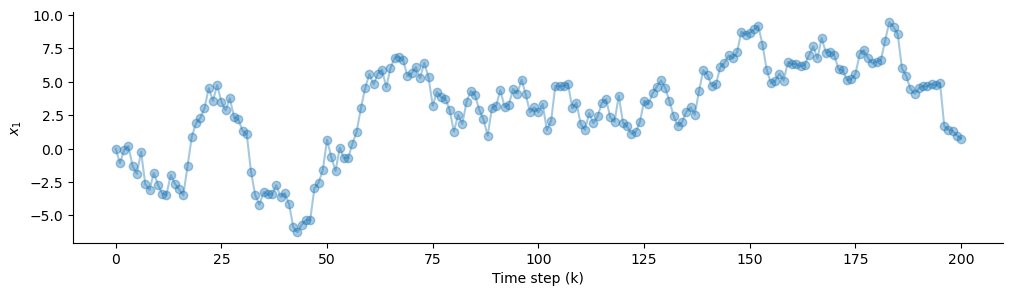

In [2]:
np.random.seed(123)

# random walk
x_1 = np.cumsum(np.random.normal(loc=0, scale=1, size=200))  # GRW
x_1 = np.insert(x_1, 0, 0)  # starting at 0

plt.figure(figsize=(12, 3))
plt.plot(x_1, "o-", alpha=0.4)
plt.xlabel("Time step (k)")
plt.ylabel("$x_{1}$")
sns.despine()

This simple process will be our first building block. Importantly here, the variability of the sensory input is constant across time: even if we don't know exactly in which direction the time series is going to move in the future, we know that it is unlikely to make certain kinds of big jumps because it is controlled by a fixed parameter, the variance $\sigma^2$.

#### Adding a drift to the random walk

The Gaussian random walk can be further parametrized by adding a drift over time. This value, often noted $\rho$, will be added at each time step:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + \rho, \sigma^2)
$$

We run the same simulation using $\rho = 0.1$ in the cell below:

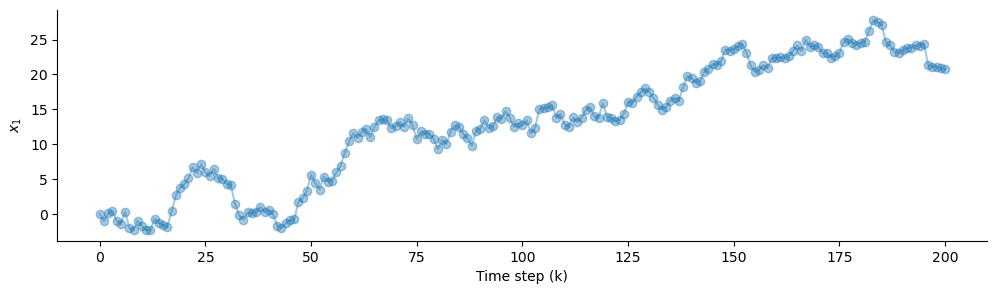

In [3]:
np.random.seed(123)

# add a drift at each time step
rho = 0.1

# random walk
x_1 = np.cumsum(np.random.normal(loc=rho, scale=1, size=200))  # GRW
x_1 = np.insert(x_1, 0, 0)  # starting at 0

plt.figure(figsize=(12, 3))
plt.plot(x_1, "o-", alpha=0.4)
plt.xlabel("Time step (k)")
plt.ylabel("$x_{1}$")
sns.despine()

#### Autoregressive processes

We can also assume that the generative process follows an [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model), in which case the value of the next iteration is weighted by a coefficient and called by an intercept, often note $\phi$ and $m$ (respectively) in the Matlab toolbox.


$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + \phi(m - x_1^{(k-1)}), \sigma^2)
$$

We repeat the same simulation below using $\phi = .4$ and $m = 12.0$.

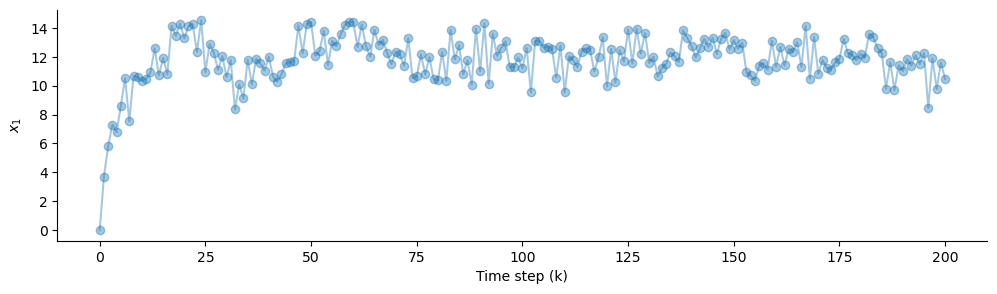

In [4]:
np.random.seed(123)

phi, m = 0.4, 12.0

# random walk with AR1 process
x_1 = [0.0]
for i in range(200):
    x_1.append(np.random.normal(x_1[i - 1] + phi * (m - x_1[i - 1]), scale=1))

plt.figure(figsize=(12, 3))
plt.plot(x_1, "o-", alpha=0.4)
plt.xlabel("Time step (k)")
plt.ylabel("$x_{1}$")
sns.despine()

### Volatility coupling
Now, we can also decide to change that and let the variance itself be a stochastic process generated by another random walk. The HGF fundamentally capitalise on this notion and generalizes the standard GRW by letting the variance $\sigma^2$ be controlled by a higher-level node.

If we take as example the two-level continuous HGF {cite:p}`2014:mathys`, the model is constituded of two states of interest, $x_1$ and $x_2$. $x_1$ is performing a GRW as previously defined, but it is also paired with $x_2$ to each other via *volatility coupling*. This means that for state $x_1$, the mean of the Gaussian random walk on trial $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(\kappa_1 x_2^{(k)} + \omega_1)
$$

with $\kappa$ as scalling parameter (by defaults in most case it is set to `1` which indicates a complete volatility coupling), and $\omega_1$ being the *evolution rate*, also refered as the tonic part of the variance, the part that is not inherited from parent nodes.

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \exp(\omega_2))
$$

The model described above can be implemented in Python as the following:

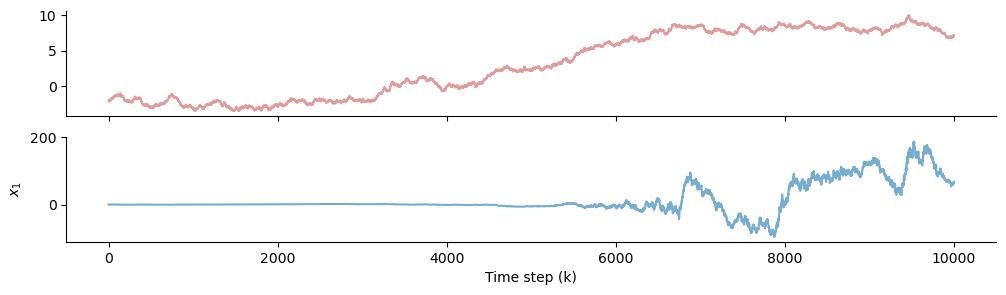

In [5]:
np.random.seed(123)
kappa_1 = 1.0
omega_1 = -6.0
omega_2 = -6.0
mu_1 = 0.0
mu_2 = -2.0
x_1 = [0]
x_2 = [-2]

# two-level hierarchical gaussian random walk
for i in range(10000):
    # x2
    pi_2 = np.exp(omega_2)
    mu_2 = np.random.normal(mu_2, pi_2**0.5)
    x_2.append(mu_2)

    # x1
    pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
    mu_1 = np.random.normal(mu_1, pi_1**0.5)

    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 3), nrows=2, sharex=True)
axs[0].plot(x_2, "-", color="indianred", alpha=0.6)

axs[1].plot(x_1, "-", alpha=0.6)
axs[1].set_xlabel("Time step (k)")
axs[1].set_ylabel("$x_{1}$")
sns.despine()

In this example, it becomes apparent that the volatility of the observation is not constant in time anymore, but depends on the values observed at the level above.

### Value coupling

This distant influence of one node on another is called *volatility coupling* (see below). However, a higher-level state can also have influence on a lower-level state by influencing its mean instead of its variance. In that case, the mean of the Gaussian random walk at one level is a function not only of its own previous value, but also the current value of the higher-level state. Such model can be formalized as follow:

$$
    x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + \alpha_{1} x_2^{(k)}, \, \exp(\omega_1)) \\
    x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \exp(\omega_2))
$$

where $\alpha$ is the value coupling between the two nodes.

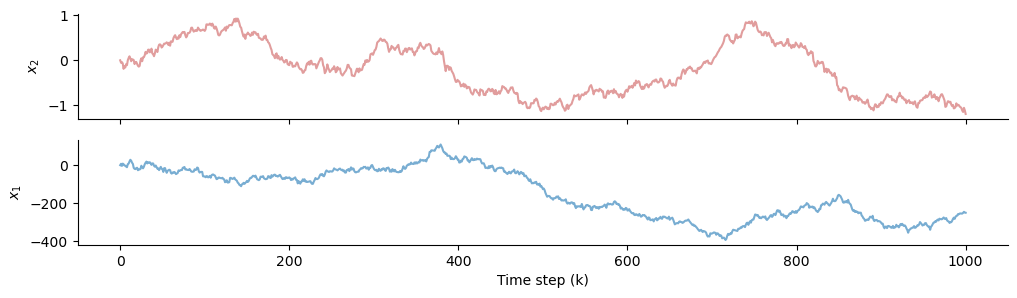

In [6]:
np.random.seed(123)
alpha_1 = 1.0
omega_1, omega_2 = 4.0, -6.0
mu_1, mu_2 = 0.0, 0.0
x_1 = [0]
x_2 = [0]

# two-level hierarchical gaussian random walk
for i in range(1000):
    # x2
    pi_2 = np.exp(omega_2)
    mu_2 = np.random.normal(mu_2, pi_2**0.5)
    x_2.append(mu_2)

    # x1
    pi_1 = np.exp(omega_1)
    mu_1 = np.random.normal(mu_1 + (alpha_1 * mu_2), pi_1**0.5)
    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 3), nrows=2, sharex=True)
axs[0].plot(x_2, "-", color="indianred", alpha=0.6)
axs[1].plot(x_1, "-", alpha=0.6)
axs[1].set_xlabel("Time step (k)")
axs[1].set_ylabel("$x_{1}$")
axs[0].set_ylabel("$x_{2}$")
sns.despine()

Finally, volatility and value coupling can operate at the same time on the same node, like in this example where $x_{1}$ has its values coupled with $x_{2}$ and its volatility coupled with $x_{3}$:

$$
x_1^{(k)}          \sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)} + \alpha_{1} x_2^{(k)}, \exp(\kappa_1 x_3^{(k)} + \omega_1)) \\
x_2^{(k)}          \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\omega_2)) \\
x_3^{(k)}          \sim \mathcal{N}(x_3^{(k)} | x_3^{(k-1)}, \, \exp(\omega_3)) \\
$$

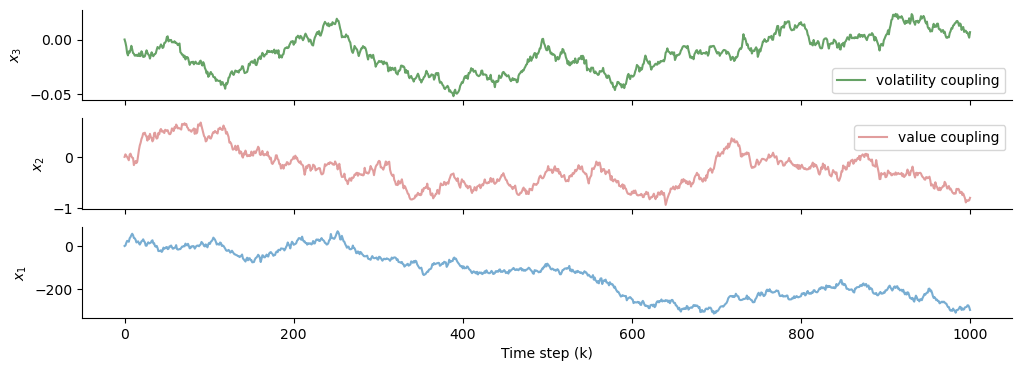

In [7]:
np.random.seed(123)
alpha_1 = 1.0
kappa_1 = 1.0
omega_1, omega_2, omega_3 = 4, -6.0, -12.0
mu_1, mu_2, mu_3 = 0.0, 0.0, 0.0
x_1 = [0]
x_2 = [0]
x_3 = [0]

# two-level hierarchical gaussian random walk
for i in range(1000):
    # x3
    pi_3 = np.exp(omega_3)
    mu_3 = np.random.normal(mu_3, pi_3**0.5)
    x_3.append(mu_3)

    # x2
    pi_2 = np.exp(omega_2)
    mu_2 = np.random.normal(mu_2, pi_2**0.5)
    x_2.append(mu_2)

    # x1
    pi_1 = np.exp(kappa_1 * mu_3 + omega_1)
    mu_1 = np.random.normal(mu_1 + (alpha_1 * mu_2), pi_1**0.5)
    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 4), nrows=3, sharex=True)
axs[0].plot(x_3, "-", color="darkgreen", alpha=0.6, label="volatility coupling")
axs[1].plot(x_2, "-", color="indianred", alpha=0.6, label="value coupling")
axs[2].plot(x_1, "-", alpha=0.6)
axs[2].set_xlabel("Time step (k)")
axs[2].set_ylabel("$x_{1}$")
axs[1].set_ylabel("$x_{2}$")
axs[0].set_ylabel("$x_{3}$")
axs[1].legend()
axs[0].legend()
sns.despine()

## Dynamic beliefs updating
### The Hierarchical Gaussian Filter in a network of predictive nodes
The coding examples introduced above illustrated generative models that can simulate data forward from a given volatility structure, with key parameters stochastically fluctuating. Based on these principles, any given latent state in the world can be modelled as having a volatility parent state, a value parent state, both, or none. When the node is an orphan, it evolves as a Gaussian random walk around its previous value with a fixed step size. Consequently, when inferring the evolution of these states, the exact belief update equations (which include the computation of new predictions, posterior values, and prediction errors, and represent an approximate inversion of this generative model, see {cite:p}`2011:mathys` depend on the nature of the coupling of a given state with its parent and children states. In particular, the nodes that implement the belief updates will communicate with their value parents via value prediction errors, or **VAPE**s, and volatility prediction errors, or **VOPE**s, with their volatility parents. Hierarchical Gaussian Filters use this as a model of the environment to make sense of new observations, also referred to as the sensory part of the HGF, or the filtering part. In this situation, new observations are coming in at the network's root and the model updates the belief structure accordingly (from bottom to top nodes). It is therefore straightforward to describe the standard two-level and three-level Hierarchical Gaussian Filters for continuous and binary inputs as the combination of value and volatility couplings (see {ref}`hgf-fig`)

```{figure} ../images/hgf.png
---
name: hgf-fig
---
The two-level and three-level Hierarchical Gaussian Filters for binary or continuous inputs, as described in {cite:p}`2014:mathys,2011:mathys`. The binary HGF has the particularity that it uses a sigmoid transform in the input node to convert continuous values into binary probabilities. For both models, volatility coupling is depicted with dashed lines, and value coupling with straight lines. The three-level HGF has one volatility layer more than the two-level HGF, which is used to estimate higher-order uncertainty.
```

```{hint}
Hierarchical Gaussian Filters are inspired by other simpler models for Bayesian filtering and reinforcement learning. These models can be seen for example as generalisation of the [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter) or the [Rescorla-Wagner model](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model). Specifically:

* A one-level HGF for continuous input can be seen as a [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter).
* A two-level binary HGF can be seen as a [Rescorla-Wagner](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model) model with an adaptive learning rate that depends on the precision of the belief.
```

### The propagation of prediction and prediction errors

Having described the model as a specific configuration of predictive nodes offer many advantages, especially in term of modularity for the user. However, the model itself is not limited to the description of the generative process that we covered in the previous examples. The most interesting, and also the more complex, part of the modelling consists of the capability for the network to update the hierarchical structure in a Bayesian optimal way as new observations are presented. These steps are defined by a set of simple, one-step update equations that represent changes in beliefs about the hidden states (i.e. the sufficient statistics of the nodes) specified in the generative model. These equations were first described in {cite:t}`2011:mathys`, and the update equations for volatility and value coupling in the generalized Hierarchical Gaussian filter (on which most of the update functions in [pyhgf](https://github.com/ilabcode/pyhgf) are based) have been described in {cite:p}`weber:2023`. The exact computations in each step especially depend on the nature of the coupling (via {term}`VAPE`s vs. {term}`VOPE`s) between the parent and children nodes. It is beyond the scope of this tutorial to dive into the derivation of these steps and we refer the interested reader to the mentioned papers. Here, we provide a general overview of the dynamic of the update sequence that supports belief updating. The computations triggered by any observation at each time point can be ordered in time as shown in the belief update algorithm.

```{note} Belief update
:name: belief-update

Let's consider a simple network containing $x_{node}$ be a {term}`node`, defined at time $k$, with children nodes defined at $x_{children}$ and parent at $x_{parent}$. The standard approach to update this network upon the presentation of a new observation is:

1. {term}`Prediction` step
    For $n$ in the network, starting from the leaves to the roots:
        Given the time elapsed since the last update
        Given the the posterior value of the node $n$
        Given the prediction from the parent nodes
        - Compute the *expected_mean* and *expected precision*

2. Beliefs propagation step
For $n$ in the network, starting from the roots to the leaves:
    1. {term}`Update` step
        Given the prediction errors received from the child nodes
        - Compute the new sufficient statistics for node $n$
    2. {term}`prediction error`
        Given the new posterior from the update step
        Given the expectation from the prediction step
        - Compute a new prediction error ({term}`VAPE` or {term}`VOPE`
        - Send it to the parent node
```

```{important}
We have placed the {term}`Prediction` step at the beginning of the update loop to account that the prediction depends on the time that has passed in between trials, which is something that can only be evaluated once the new input arrives. This is because we usually think about the beginning of a trial/time point as starting with receiving a new input and of a prediction as being present before that input is received. For implementational purposes, it is most convenient to only compute the prediction once the new input (and with it its arrival time) enters. However, it makes most sense to think of the prediction as happening continuously between the time points, but this is not something that is tracked continuously by the model.
```

## Glossary

```{glossary}

Node
    HGF models are defined as networks of probabilistic nodes. A node is defined by its parameters (e.g. sufficient statistics, coupling values...) and by its connection with other nodes. The dependencies structure can have more than one dimension (i.e. there are many kinds of dependencies between nodes, especially here the volatility coupling and the value coupling).

Prediction
    At every time $k$, a continuous node $i$ is defined by its sufficient statistics, the mean $\mu_i^{(k)}$ and its inverse variance, or precision, $\pi_i^{(k)}$, and hold predictions about the next observed values, denoted $\hat{\mu}_i^{(k)}$ and $\hat{\pi}_i^{(k)}$.

Prediction error
    Difference between the top-down predictions at node $i$ that is inherited from parents, and the bottom-up incoming observations passed by children nodes.

Update
    At each time $k$, a new value is observed at the input node and the sufficient statistics of the nodes (i.e. beliefs) are updated accordingly from the lower part to the upper part of the structure.

VAPE
    Value prediction error. The error of top-down prediction concerning the node's value ($\mu_i$).

VOPE
    Volatility prediction error. The error of top-down prediction concerning the node's volatility ($\pi_i$).

```

# System configuration

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Mon Nov 06 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.9
jax   : 0.4.14
jaxlib: 0.4.14

numpy     : 1.22.0
seaborn   : 0.12.2
matplotlib: 3.7.1

Watermark: 2.4.3

